# The Early Net: Preventing Stroke in Older Adults with Proactive, Multifactorial Monitoring

Zhang Chenge (157)

## Executive Summary

Research suggests that stroke is related to a variety of factors, involving BP, medical history of TIA and HT.
Further investigations found even more factors related to stroke risk, and mandate a dual approach: combining evidence-based screening thresholds with tailored health technology to flag high-risk individuals and support their ongoing health management.
This strategy not only improves early detection but also ensures health resources are used wisely. These findings fill gaps in current programs by making screening more practical on stroke prevention in the aged population.

## Literature Review

### Problem Statement

Stroke occurs when blood supply to a part of brain is cut off, causing brain tissue damage (Centers for Disease Control and Prevention, 2024).
It is well-known that stroke is related to a number of factors.

For example, hypertension (HT), or high blood  pressure (BP), is a leading cause of stroke.
It is found that poor treatment of HT often results in higher stroke risk (Han et al., 2017).
Having a TIA (triansient ischemic attack) also means a higher risk of developing stroke (Centers for Disease Control and Prevention, 2024).
In Hong Kong, stroke was the 4th most common cause of death in Hong Kong in 2024 (Centre for Health Prevention, 2025), causing 2,911 deaths per year.
It is also found that stroke has a higher incidence among those aged over 55 (Boehme et al., 2017).

The newly-introduced long-term monitoring scheme, CDCC (Chronic Disease Co-care) Pilot Scheme (Primary Healthcare Commision, n.d.) 
provides screening on HT, diabetes and blood lipid to older adults (>45 years), with possible follow-up actions to mediate HT conditions.
However, it only aims to screen and treat chronic diseases, and not directly prevent accute occurrences of other diseases (such as stroke)
caused by chronic ones.

Also, basing prevention only on these screening results may miss risk caused by other well-known
factors of stroke, such as medical history of TIA. In short, this screening of HT is not effective enough to mediate stroke risk in
older adults.

As active measures against stroke are not being taken, stroke will continue to be a dominant problem for the aged population.

### Significance

The unfilled gap of CDCC causes stroke risk to go unnoticed -- even if screening shows signs of HT or diabetes,
treatment from CDCC Pilot Scheme would focus on treating the chronic disease itself, not accute illnesses like stroke caused by them.

If, alongside managing chronic diseases, further estimations of stroke risk can be performed, proactive actions can be taken against stroke. This means
a higher rate of stroke being caught early, saving thousands each year.

### Objectives

This study aims to integrate proactive BP monitoring alongside monitoring on other factors
such as medical history and lifestyle in the CDCC, to prevent stroke in the aged population.

Specifically,

1. In in adults aged 45-80, identify high-risk groups with medical conditions or lifestyle factors (e.g., diet or consumption of certain drinks) that could lead to higher stroke risk, therefore defining groups for prioritized stroke risk monitoring.
2. Assess whether baseline treatment status (e.g., use of HT drugs or diabetes treatment) could mediate or reduce correlation between BP values and stroke risk.
3. Explore correlation between recent symptoms and stroke risk.
4. Generate easy-to-apply screening criteria that prioritize individuals for proactive stroke risk monitoring, and report their predictive performance and population yield.
5. Propose health policy and innovative health technology to implement proactive BP monitoring schemes to predict and prevent stroke in the aged population.

## Data analysis

### Methodology

A retrospective cohort is used to compare trends in BP (systolic and diastolic) that may lead to stroke, and correlation between symptoms reported at wave 
preceeding stroke to find correlation between occurrence of symptoms and stroke risk.

At baseline, individuals aged 45-80 and free of stroke are included. Only individuals that appeared across 3 or more “waves” (statistical periods) are included.

### Data Import
This part processes necesary data to prepare for analysis.

Data source: https://chns.cpc.unc.edu/

China Health and Nutrition Survey. Licensed under CC0.

#### Abbrevations
- CHNS - China Health and Nutrition Survey
- CHNS_Idv - Individual datasets from CHNS

All datasets provided are in the SAS format. They are read into Pandas `DataFrame`s first for further processing.

In [97]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from matplotlib import pyplot as plt
import scipy.stats as stats

from IPython.display import HTML, display  # For table output visualization

%matplotlib widget

#### Clean up Data

CHNS uses a set of codes to name their data colums, which are available with the datasets. Individuals have a unique ID assigned to them, which is persistent across waves (years where CHNS is taken place). This means that one can combine individual data across waves for longitudinal study.

For the sake of simplicity, only statistical data collected that are related to cardiovascular and cerebrovascular problems are taken into consideration. The following are factors included.

- Age
- Gender
- Recent symptoms
    - Had a headache in last 4 weeks?
    - Had chest pain in last 4 weeks?
    - Felt exhausted in last 4 weeks?
    - Had bleeding of unknown cause in last 4 weeks?
    - Had weight loss of unknown cause in last 4 weeks?
- Systolic blood pressure (take mean of 3 values)
- Diastolic blood pressure (take mean of 3 values)
- BMI (calculated from height and weight)
    - Height
    - Weight
- Has hypertension?
    - Is the patient taking HT drugs?
- Has diabetes?
- Has myocardiac infarction (MI)?
- Has apoplexy?
- Had a transient ischemic attack (TIA) in the past year?
- Had ever smoked?
    - Still smoking or quitted?
    - Number of cigarettes smoked per day.
- Drinks beer?
    - Number of bottles of beer per week
    - Frequency of drinking beer per week
- Drinks tea?
    - Number of bottles of tea per week
    - Frequency of drinking tea per week
- Drinks coffee?
    - Number of bottles of coffee per week
    - Frequency of drinking coffee per week

Frequency of all `_Freq` columns are encoded as follows:

1. Almost every day
2. 4-5 times a week
3. 2-3 times a week
4. No more than once a week
5. 2-3 times in past 30 days
6. Only once in past 30 days
7. None in past 30 days

In [98]:
hlth_data = pd.read_sas("CHNS_Idv/hlth_12.sas7bdat")

hlth_data["wave"] = hlth_data["wave"].astype(int)
hlth_data["IDind"] = hlth_data["IDind"].astype(int)
hlth_cols = {
    "IDind": "ID",
    "M24B_3": "Headache_Last4",
    "M24B_7": "Chestpain_Last4",
    "M24B_14": "Exhaustion_Last4",
    "M24B_15": "Unknown_Bleed_Last4",
    "M24B_16": "Unknown_WghtLoss_Last4",
    "M26": "Sought_Medcare",
    "wave": "Wave",
}

hlth_data = hlth_data[[*hlth_cols.keys()]]
hlth_data = hlth_data.rename(columns=hlth_cols)
hlth_data = hlth_data.sort_values("ID")

hlth_data = hlth_data.fillna(0)

hlth_data = hlth_data.reset_index(drop=True)
hlth_data

,ID,Headache_Last4,Chestpain_Last4,Exhaustion_Last4,Unknown_Bleed_Last4,Unknown_WghtLoss_Last4,Sought_Medcare,Wave
0,111101001001,1.0,0.0,0.0,0.0,0.0,0.0,2011
1,111101001001,0.0,0.0,0.0,0.0,0.0,0.0,2015
2,111101001002,0.0,0.0,0.0,0.0,0.0,0.0,2011
3,111101001002,0.0,0.0,0.0,0.0,0.0,0.0,2015
4,111101002001,1.0,0.0,0.0,0.0,0.0,0.0,2011
...,...,...,...,...,...,...,...,...
127756,552304020003,0.0,0.0,0.0,0.0,0.0,0.0,2015
127757,552304161001,0.0,0.0,0.0,0.0,0.0,0.0,2015
127758,552304161002,0.0,0.0,0.0,0.0,0.0,0.0,2015
127759,552304161003,0.0,0.0,0.0,0.0,0.0,0.0,2015


In [99]:
exam_data = pd.read_sas("CHNS_Idv/pexam_00.sas7bdat")

exam_cols = {
    "SYSTOL1": "Systole_BP1",
    "SYSTOL2": "Systole_BP2",
    "SYSTOL3": "Systole_BP3",
    "DIASTOL1": "Diastole_BP1",
    "DIASTOL2": "Diastole_BP2",
    "DIASTOL3": "Diastole_BP3",
    "HEIGHT": "Height",
    "WEIGHT": "Weight",
    "U22": "Has_HT",
    "U23": "HT_Age",
    "U24": "HT_OnHTDrugs",
    "U24A": "Has_Diab",
    "U24B": "Diab_Age",
    "U24C": "Diab_OnDiet",
    "U24D": "Diet_OnWeightCtrl",
    "U24E": "Diab_OnOralMeds",
    "U24F": "Diab_OnInsulin",
    "U24J": "Has_MI",
    "U24K": "MI_Age",
    "U24L": "Has_Apopl",
    "U24M": "Apopl_Age",
    "U24V": "Had_TIA",
    "U24T": "TIA_Age",
    "U25": "Had_Smoke",
    "U26": "Age_Smoke",
    "U27": "Still_Smoking",
    "U28": "Num_Cigs_Day",
    "U34": "Drink_Tea",
    "U35": "Freq_Tea",
    "U36": "Avg_Tea_Cups_Day",
    "U37": "Drink_Coffee",
    "U38": "Freq_Coffee",
    "U39": "Avg_Coffee_Cups_Day",
    "U40": "Drink_Beer",
    "U41": "Freq_Beer",
    "U42": "Avg_Beer_Bottles_Day",
    "IDind": "ID",
    "WAVE": "Wave",
}

exam_data["WAVE"] = exam_data["WAVE"].astype(int)
exam_data["IDind"] = exam_data["IDind"].astype(int)

exam_data = exam_data[[*exam_cols.keys()]]
exam_data = exam_data.rename(columns=exam_cols)
exam_data = exam_data.sort_values("ID")

# Deal with NaN
exam_data = exam_data[exam_data["Systole_BP1"].notna()]
exam_data = exam_data[exam_data["Height"].notna()]
exam_data = exam_data[exam_data["Weight"].notna()]

exam_data = exam_data.fillna(0)

# Take mean of SBP and DBP
exam_data["SBP_Mean"] = (
    sum([exam_data["Systole_BP1"], exam_data["Systole_BP2"], exam_data["Systole_BP3"]])
    / 3
)
exam_data["DBP_Mean"] = (
    sum(
        [
            exam_data["Diastole_BP1"],
            exam_data["Diastole_BP2"],
            exam_data["Diastole_BP3"],
        ]
    )
    / 3
)

# Calculate BMI
exam_data["Height"] /= 100
exam_data["BMI"] = exam_data["Weight"] / exam_data["Height"] ** 2

for column_name in exam_cols.values():
    if (
        column_name.startswith("Has_")
        or column_name.startswith("Drink_")
        or column_name.startswith("Had")
    ):
        exam_data[column_name] = exam_data[column_name].astype(int)

exam_data = exam_data.reset_index(drop=True)
exam_data

,Systole_BP1,Systole_BP2,Systole_BP3,Diastole_BP1,Diastole_BP2,Diastole_BP3,Height,Weight,Has_HT,HT_Age,...,Freq_Coffee,Avg_Coffee_Cups_Day,Drink_Beer,Freq_Beer,Avg_Beer_Bottles_Day,ID,Wave,SBP_Mean,DBP_Mean,BMI
0,140.0,138.0,140.0,90.0,86.0,88.0,1.660,72.0,1,30.0,...,0.0,0.0,0,0.0,0.0,111101001001,2011,139.333333,88.000000,26.128611
1,120.0,124.0,120.0,70.0,72.0,68.0,1.570,53.0,1,35.0,...,0.0,0.0,0,0.0,0.0,111101001002,2011,121.333333,70.000000,21.501886
2,120.0,126.0,120.0,80.0,82.0,76.0,1.680,83.5,1,1.0,...,0.0,0.0,0,0.0,0.0,111101002001,2011,122.000000,79.333333,29.584751
3,140.0,138.0,140.0,80.0,76.0,86.0,1.690,63.0,1,11.0,...,0.0,0.0,0,0.0,0.0,111101003001,2011,139.333333,80.666667,22.058051
4,110.0,114.0,110.0,78.0,80.0,76.0,1.600,50.0,0,0.0,...,0.0,0.0,0,0.0,0.0,111101003002,2011,111.333333,78.000000,19.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94528,100.0,102.0,102.0,70.0,68.0,70.0,1.423,36.9,0,0.0,...,0.0,0.0,0,0.0,0.0,552304018003,2011,101.333333,69.333333,18.222861
94529,150.0,148.0,150.0,96.0,94.0,94.0,1.556,59.8,0,0.0,...,0.0,0.0,0,0.0,0.0,552304019001,2011,149.333333,94.666667,24.699149
94530,108.0,108.0,106.0,64.0,66.0,62.0,1.504,54.2,0,0.0,...,0.0,0.0,0,0.0,0.0,552304019002,2011,107.333333,64.000000,23.960927
94531,124.0,126.0,126.0,88.0,90.0,88.0,1.664,56.1,0,0.0,...,0.0,0.0,0,0.0,0.0,552304020001,2011,125.333333,88.666667,20.260783


In [100]:
birth_data = pd.read_sas("CHNS_Idv/mast_pub_12.sas7bdat")

birth_data["Idind"] = birth_data["Idind"].astype(int)
birth_data["GENDER"] = birth_data["GENDER"].astype(int)

birth_cols = {"Idind": "ID", "GENDER": "Gender", "WEST_DOB_Y": "DOB"}
birth_data = birth_data[[*birth_cols.keys()]]
birth_data = birth_data.rename(columns=birth_cols)
birth_data = birth_data.dropna()
birth_data = birth_data.drop_duplicates()

birth_data["DOB"] = birth_data["DOB"].astype(int)
birth_data = birth_data.sort_values("ID")

birth_data = birth_data.reset_index(drop=True)
birth_data

,ID,Gender,DOB
0,111101001001,1,1935
1,111101001002,2,1936
2,111101002001,2,1964
3,111101003001,1,1932
4,111101003002,2,1937
...,...,...,...
39646,552304020003,1,2009
39647,552304161001,1,1971
39648,552304161002,1,2011
39649,552304161003,2,2008


#### Merge and filter

Merge health data and health examination data. Then filter out individuals:

- Not aged 45-80 at baseline
- Not present in more than 2 "waves"

In [101]:
merged = pd.merge(
    hlth_data, exam_data, on=["ID", "Wave"], how="inner", suffixes=("_hlth", "_exam")
)
merged = merged.drop_duplicates()

persons = {}
for pid, df_person in merged.groupby("ID"):
    current_person = df_person.sort_values("Wave")

    # Exclude if only in one wave
    shape = current_person.shape
    if shape[0] < 3:
        continue

    current_birth_data = birth_data.loc[birth_data["ID"] == pid]
    year_born = current_birth_data["DOB"]
    if year_born.empty:
        continue

    year_born = year_born.iat[0]
    current_wave = current_person["Wave"]
    current_age = current_wave - year_born
    if not (current_age.between(45, 80).any()):
        continue

    current_person["Age"] = current_person["Wave"] - year_born

    current_person = current_person.drop(columns=["ID"])
    current_person = current_person.reset_index(drop=True)
    persons[pid] = current_person

Remove population that has had a apoplexy (stroke) at baseline.

In [102]:
filtered_persons = {}
excluded_ids = []

for pid, df in persons.items():
    df = df.sort_values("Wave").reset_index(drop=True)
    baseline_wave = int(df.loc[0, "Wave"])
    has_prevalent = (
        df.loc[df["Wave"] <= baseline_wave, "Has_Apopl"].fillna(0).astype(int).any()
    )
    if not has_prevalent:
        filtered_persons[pid] = df
    else:
        excluded_ids.append(pid)

persons = filtered_persons

### Hazard ratio of variables

This part will asess correlation between factors recorded in the datasets and stroke risk.

**Strategy**
Two rounds of Cox model evaluations are created to predict the hazard ratio of variables.

**First round**
A model is fitted from the following variables, each of which is used as a predictor:

- `Time_Yrs` - Event follow-up time
- `Event` - Whether stroke occured
- `Slope_SBP` - SBP slope from start to end of waves
- `Slope_DBP` - DBP slope from start to end of waves
- `Mean_SBP` - Mean of SBP from start to end of waves
- `Mean_DBP` - Mean of DBP from start to end of waves
- `Age_Baseline` - Age at baseline t=0
- Variation of BP
    - `SD_SBP` - Standard deviation of SBP
    - `SD_DBP` - Standard deviation of DBP
    - `ARV_SBP` - Average Real Variability of SBP
    - `ARV_DBP` - Average Real Variability of DBP
- `BMI` - BMI
- `Has_Untreated_HT` - 0-1 value whether the individual has untreated HT conditions (i.e., has HT but not taking antihypertensive drugs)
- `Has_Untreated_Diab` - 0-1 value whether the individual has untreated diabetes
- `Has_Treated_HT` - 0-1 value whether the individual has controlled HT conditions (i.e., has HT but not taking antihypertensive drugs)
- `Has_Treated_Diab` - 0-1 value whether the individual has controlled diabetes
- `Has_HT` - 0-1 value whether the individual has HT conditions (i.e., has HT but not taking antihypertensive drugs)
- `Has_Diab` - 0-1 value whether the individual has diabetes
- `Has_MI` - 0-1 value whether the individual has untreated MI
- `Had_TIA` - 0-1 value whether the individual had a TIA
- `Still_Smoking` - 0-1 value whether the individual is still smoking
- Life habit factors
    - `Avg_Beer_Bottles_Day` - Average number of bottles of beer consumed per day.
    - `Avg_Coffee_Cups_Day` - Average number of cups of coffee consumed per day.
    - `Avg_Tea_Cups_Day` - Average number of cups of tea consumed per day.

In this Cox model, the following variables are scaled to ensure better visibility.
- Means of SBP and DBP - Scaled by 10 times (i.e., per 10 mmHg increase)
- BMI - Scaled by 2 times

**Second round** Correlation between the years of having the following conditions and stroke risk is evaluated separately,

- `TIA_Years` - Years after TIA before stroke
- `HT_Years` - Years of having HT before stroke
- `Diab_Years` - Years of having diabetes before stroke
- `MI_Years` - Years after having MI before stroke.

All of these variables are calculated as such,

1. Calculate age when stroke occured (from `stroke_wave - baseline_wave + baseline_age`) **(1)**
2. Find age when condition is diagnosed **(2)**
3. Subtract **(2)** from **(1)** to find years of having the condition before stroke.

#### Feature extraction

Extracts features (baseline covariates) from dataset for each individual.

This converts the wave dataset created earlier into a person dataset, containing the same factors but merged together for each individual.

In [103]:
def trace_years_before_stroke(df: pd.DataFrame, *, col: str, stroke_age: float) -> int:
    if (df[col] > 0).any():
        return df[col][df[col] != 0].iloc[-1]
    return np.nan

In [104]:
rows = []
for pid, df in persons.items():
    df = df.sort_values("Wave").reset_index(drop=True)

    baseline_wave = int(df.loc[0, "Wave"])

    sbp_ts = df[["Wave", "SBP_Mean"]]
    dbp_ts = df[["Wave", "DBP_Mean"]]

    n_obs_sbp = len(sbp_ts)
    n_obs_dbp = len(dbp_ts)

    mean_sbp = sbp_ts["SBP_Mean"].mean()
    mean_dbp = dbp_ts["DBP_Mean"].mean()

    sd_sbp = sbp_ts["SBP_Mean"].std(ddof=1)
    sd_dbp = dbp_ts["DBP_Mean"].std(ddof=1)

    arv_sbp = np.mean(np.abs(np.diff(sbp_ts["SBP_Mean"].values)))
    arv_dbp = np.mean(np.abs(np.diff(dbp_ts["DBP_Mean"].values)))

    first_sbp = sbp_ts["SBP_Mean"].iloc[0]
    first_dbp = dbp_ts["DBP_Mean"].iloc[0]
    last_sbp = sbp_ts["SBP_Mean"].iloc[-1]
    last_dbp = dbp_ts["DBP_Mean"].iloc[-1]

    # Fit linear slope model
    slope_sbp = np.nan
    slope_dbp = np.nan

    years = sbp_ts["Wave"].values
    vals = sbp_ts["SBP_Mean"].astype(float).values
    slope_sbp, _ = np.polyfit(years, vals, 1)

    vals = dbp_ts["DBP_Mean"].astype(float).values
    slope_dbp, _ = np.polyfit(years, vals, 1)

    # event determination and follow-up time
    post = df[df["Wave"] >= baseline_wave]
    stroke_rows = post[post["Has_Apopl"] == 1]
    if len(stroke_rows) > 0:
        event = 1
        event_wave = stroke_rows["Wave"].iloc[0]
        time_yrs = event_wave - baseline_wave
    else:
        event = 0
        event_wave = np.nan
        time_yrs = df["Wave"].iloc[-1] - baseline_wave

    # baseline covariates
    baseline_row = df.loc[0]
    age_baseline = baseline_row["Age"]
    bmi = baseline_row["BMI"]
    has_untreated_ht = baseline_row["Has_HT"] and not baseline_row["HT_OnHTDrugs"]
    has_treated_ht = baseline_row["Has_HT"] and baseline_row["HT_OnHTDrugs"]
    has_untreated_diab = baseline_row["Has_Diab"] and not (
        baseline_row["Diab_Age"]
        or baseline_row["Diab_OnDiet"]
        or baseline_row["Diet_OnWeightCtrl"]
        or baseline_row["Diab_OnOralMeds"]
        or baseline_row["Diab_OnInsulin"]
    )
    has_treated_diab = baseline_row["Has_Diab"] and (
        baseline_row["Diab_Age"]
        or baseline_row["Diab_OnDiet"]
        or baseline_row["Diet_OnWeightCtrl"]
        or baseline_row["Diab_OnOralMeds"]
        or baseline_row["Diab_OnInsulin"]
    )
    has_mi = baseline_row["Has_MI"]
    still_smoking = baseline_row["Still_Smoking"]
    years_with_ht = age_baseline
    avg_beer_day = baseline_row["Avg_Beer_Bottles_Day"]
    avg_tea_day = baseline_row["Avg_Tea_Cups_Day"]
    avg_coffee_day = baseline_row["Avg_Coffee_Cups_Day"]

    stroke_age = age_baseline + (event_wave - baseline_wave)
    # Try to trace back TIA
    tia_years = trace_years_before_stroke(df, col="TIA_Age", stroke_age=stroke_age)
    ht_years = trace_years_before_stroke(df, col="HT_Age", stroke_age=stroke_age)
    diab_years = trace_years_before_stroke(df, col="Diab_Age", stroke_age=stroke_age)
    mi_years = trace_years_before_stroke(df, col="MI_Age", stroke_age=stroke_age)

    row = {
        "ID": pid,
        "Baseline_Wave": baseline_wave,
        "N_Obs_SBP": n_obs_sbp,
        "N_Obs_DBP": n_obs_dbp,
        "Mean_SBP": mean_sbp,
        "Mean_DBP": mean_dbp,
        "SD_SBP": sd_sbp,
        "SD_DBP": sd_dbp,
        "ARV_SBP": arv_sbp,
        "ARV_DBP": arv_dbp,
        "Slope_SBP": slope_sbp,
        "Slope_DBP": slope_dbp,
        "Event": int(event),
        "Time_Yrs": time_yrs,
        "Event_Wave": event_wave,
        "Age_Baseline": age_baseline,
        "BMI": bmi,
        "Has_Untreated_HT": has_untreated_ht,
        "Has_Treated_HT": has_treated_ht,
        "Has_HT": baseline_row["Has_HT"],
        "HT_Years": ht_years,
        "Has_Untreated_Diab": has_untreated_diab,
        "Has_Treated_Diab": has_treated_diab,
        "Has_Diab": baseline_row["Has_Diab"],
        "Diab_Years": diab_years,
        "Had_TIA": baseline_row["Had_TIA"],
        "TIA_Years": tia_years,
        "Has_MI": has_mi,
        "MI_Years": mi_years,
        "Still_Smoking": still_smoking,
        "Avg_Beer_Bottles_Day": avg_beer_day,
        "Avg_Coffee_Cups_Day": avg_coffee_day,
        "Avg_Tea_Cups_Day": avg_tea_day,
    }
    rows.append(row)

df_person = pd.DataFrame(rows)
df_person = df_person.dropna(subset=["Time_Yrs"])

df_person

,ID,Baseline_Wave,N_Obs_SBP,N_Obs_DBP,Mean_SBP,Mean_DBP,SD_SBP,SD_DBP,ARV_SBP,ARV_DBP,...,Has_Diab,Diab_Years,Had_TIA,TIA_Years,Has_MI,MI_Years,Still_Smoking,Avg_Beer_Bottles_Day,Avg_Coffee_Cups_Day,Avg_Tea_Cups_Day
0,211101001001,1989,4,4,96.500000,66.666667,40.676228,29.027446,30.333333,20.555556,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
1,211101001002,1989,4,4,96.000000,69.333333,43.246922,31.633316,42.444444,30.222222,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
2,211101003001,1991,3,3,117.666667,78.666667,6.806859,4.041452,6.500000,5.500000,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0
3,211101003002,1991,6,6,114.333333,82.777778,7.336363,5.294302,4.133333,6.800000,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
4,211101005001,1989,3,3,90.555556,65.555556,41.910398,30.291791,49.166667,36.666667,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7819,522404020001,1991,3,3,110.888889,76.000000,8.282065,6.000000,7.333333,9.000000,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0
7820,522404020002,1991,5,5,95.866667,62.933333,3.753517,4.578937,4.000000,4.166667,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
7821,522404042001,1997,5,5,113.200000,74.200000,12.493554,9.426912,20.000000,10.333333,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0
7822,522404082001,2004,3,3,126.222222,76.444444,16.334467,5.178302,16.333333,6.333333,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0


#### Helper function for evaluating Cox model

This `evaluate_cox` function takes in the persons `DataFrame`, then fits a Cox model on it.

In [105]:
def evaluate_cox(cph_df: pd.DataFrame, *, scale_map: dict, tight_layout: bool = False):
    cph_df = cph_df.dropna()

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(cph_df, duration_col="Time_Yrs", event_col="Event")
    cph.print_summary(decimals=4)

    summary_df = cph.summary

    # normalize expected column names (handle lifelines naming)
    col_map = {
        "se(coef)": "se",
        "coef lower 95%": "coef_lower",
        "coef upper 95%": "coef_upper",
    }
    summary_df = summary_df.rename(columns=col_map)
    summary_df["scale"] = summary_df.index.map(scale_map).fillna(1.0)

    # compute display coef and CI on coef scale (apply scaling to coef and CI)
    summary_df["coef_disp"] = summary_df["coef"] * summary_df["scale"]
    summary_df["coef_lower_disp"] = summary_df["coef_lower"] * summary_df["scale"]
    summary_df["coef_upper_disp"] = summary_df["coef_upper"] * summary_df["scale"]

    # exponentiate to HR scale (display)
    summary_df["hr"] = np.exp(summary_df["coef_disp"])
    summary_df["hr_lower"] = np.exp(summary_df["coef_lower_disp"])
    summary_df["hr_upper"] = np.exp(summary_df["coef_upper_disp"])

    # order variables for plotting (you can sort by coef_disp or HR)
    summary_df = summary_df.sort_values("hr")

    # plotting
    plt.figure(figsize=(12, max(2, int(summary_df.shape[0] * 0.5))))
    y_pos = np.arange(len(summary_df))
    hr = summary_df["hr"].values
    hr_err_low = hr - summary_df["hr_lower"].values
    hr_err_high = summary_df["hr_upper"].values - hr
    variable_labels = summary_df.index.values

    # horizontal error bars on log scale (plot HR on log x-axis)
    plt.errorbar(hr, y_pos, xerr=[hr_err_low, hr_err_high], fmt="o", capsize=3)
    plt.axvline(1.0, color="red", linestyle="--", linewidth=1)  # null hazard ratio

    plt.yticks(y_pos, variable_labels)
    plt.xscale("log")
    plt.xlabel("Hazard Ratio (log scale)")
    plt.title("Hazard ratios with 95% CIs")

    # annotate HR values to the right
    for i, (h, lo, hi) in enumerate(
        zip(hr, summary_df["hr_lower"], summary_df["hr_upper"])
    ):
        plt.text(hi * 1.05, i, f"{h:.4f} [{lo:.4f}, {hi:.4f}]", va="center", fontsize=8)

    if tight_layout:
        plt.tight_layout()
    plt.show()

#### First round of Cox model

This round evaluates stroke risk on the entire dataset, with a subset of factors,

- Slope, mean, standard deviation, ARV of SBP and DBP
- Age at baseline
- BMI
- Whether individual has HT or diabetes
- Whether individual has HT or diabetes under treatment or under no treatment
- Whether individual is still smoking regularly
- Consumption of beer, coffee and tea

<lifelines.CoxPHFitter: fitted with 7824 total observations, 7497 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7824
number of events observed = 327
   partial log-likelihood = -2660.8387
         time fit was run = 2025-12-30 09:34:38 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
Slope_SBP            -0.0132    0.9869    0.0130         -0.0387          0.0123              0.9621              1.0124
Slope_DBP            -0.0262    0.9742    0.0210         -0.0673          0.0149              0.9350              1.0150
Mean_SBP              0.0138    1.0139    0.0020          0.0099          0.0176              1.0100              1.0178
Mean_DBP              0.0198    1.0200    0.0034          0.0130          0.0265              1.0131              1.0269
SD_SBP                0.0020    1.0020    0.0031         -0.0041          0.0081              0.9959              1.0082
SD_DBP                0.0015    1.0015    0.0050         -0.0083          0.0113              0.9918              1.0114
ARV_SBP               0.0052    1.0053    0.0029         -0.0005          0.0110              0.9995              1.0110
ARV_DBP               0.0063    1.0063    0.0045         -0.0026          0.0151              0.9975              1.0152
Age_Baseline          0.0173    1.0174    0.0025          0.0124          0.0221              1.0124              1.0224
BMI                   0.0316    1.0321    0.0096          0.0128          0.0503              1.0129              1.0516
Has_Untreated_HT      0.3608    1.4344    0.1917         -0.0150          0.7366              0.9851              2.0887
Has_Untreated_Diab   -1.1558    0.3148    1.5989         -4.2896          1.9779              0.0137              7.2274
Has_Treated_HT        0.5134    1.6710    0.1456          0.2280          0.7988              1.2561              2.2228
Has_Treated_Diab      0.0161    1.0163    0.0064          0.0037          0.0286              1.0037              1.0290
Has_HT                0.1927    1.2125    0.0933          0.0097          0.3756              1.0098              1.4559
Has_Diab              0.1426    1.1533    0.1813         -0.2128          0.4981              0.8083              1.6455
Has_MI               -0.0136    0.9865    0.2011         -0.4076          0.3805              0.6652              1.4630
Still_Smoking         0.0608    1.0627    0.0639         -0.0645          0.1861              0.9375              1.2045
Avg_Beer_Bottles_Day  0.0004    1.0004    0.0209         -0.0406          0.0413              0.9602              1.0422
Avg_Coffee_Cups_Day   0.0725    1.0752    0.2120         -0.3431          0.4881              0.7096              1.6292
Avg_Tea_Cups_Day      0.0114    1.0115    0.0173         -0.0225          0.0453              0.9778              1.0464

                      cmp to       z      p  -log2(p)
covariate                                            
Slope_SBP             0.0000 -1.0131 0.3110    1.6850
Slope_DBP             0.0000 -1.2489 0.2117    2.2399
Mean_SBP              0.0000  6.9975 <5e-05   38.4810
Mean_DBP              0.0000  5.7414 <5e-05   26.6662
SD_SBP                0.0000  0.6426 0.5205    0.9421
SD_DBP                0.0000  0.3068 0.7590    0.3978
ARV_SBP               0.0000  1.7974 0.0723    3.7904
ARV_DBP               0.0000  1.3930 0.1636    2.6115
Age_Baseline          0.0000  6.9227 <5e-05   37.7152
BMI                   0.0000  3.3001 0.0010   10.0147
Has_Untreated_HT      0.0000  1.8816 0.0599    4.0614
Has_Untreated_Diab    0.0000 -0.7229 0.4697    1.0901
Has_Treated_HT        0.0000 

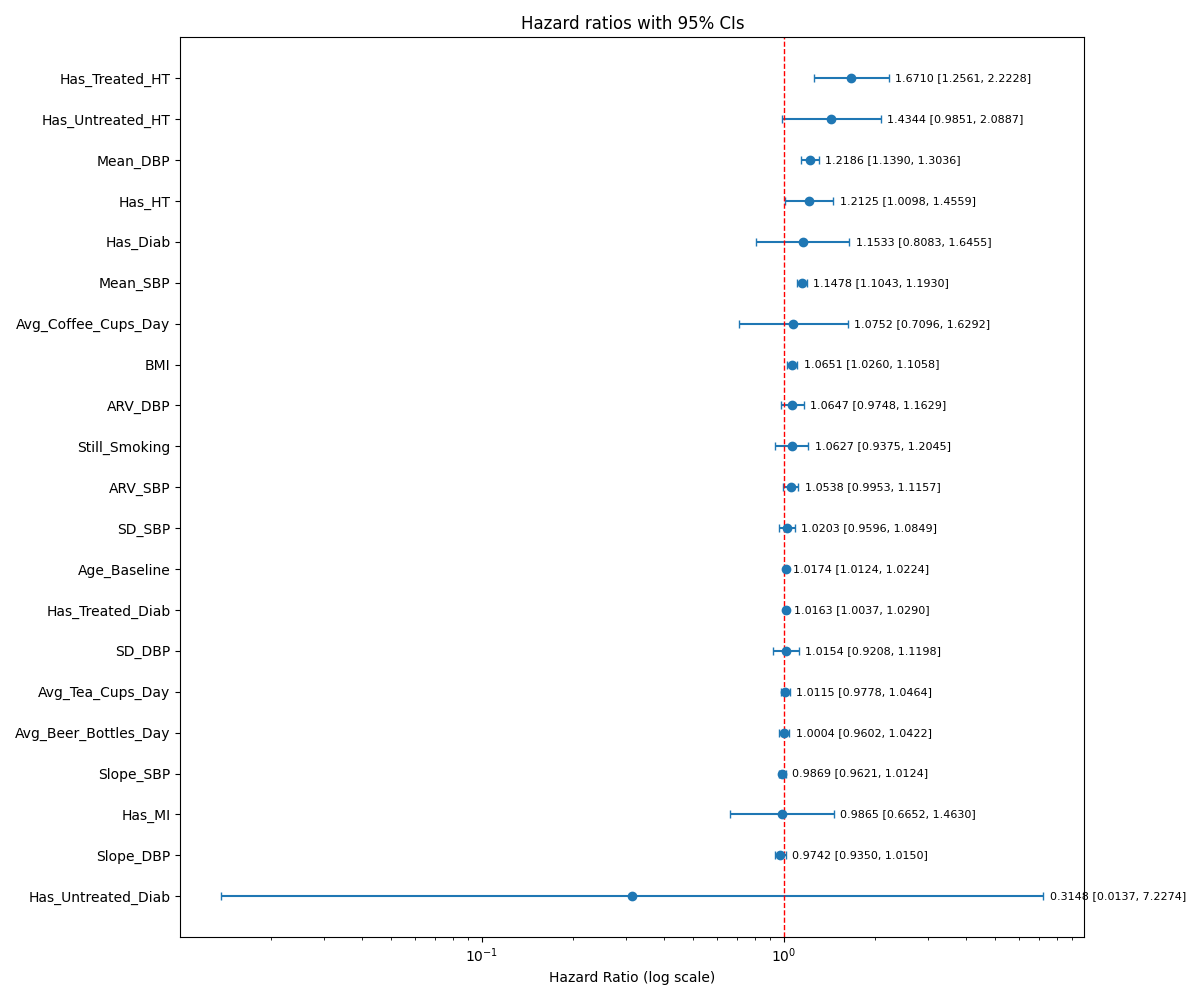

In [106]:
cph_df = df_person[
    [
        "Time_Yrs",
        "Event",
        "Slope_SBP",
        "Slope_DBP",
        "Mean_SBP",
        "Mean_DBP",
        "SD_SBP",
        "SD_DBP",
        "ARV_SBP",
        "ARV_DBP",
        "Age_Baseline",
        "BMI",
        "Has_Untreated_HT",
        "Has_Untreated_Diab",
        "Has_Treated_HT",
        "Has_Treated_Diab",
        "Has_HT",
        "Has_Diab",
        "Has_MI",
        "Still_Smoking",
        "Avg_Beer_Bottles_Day",
        "Avg_Coffee_Cups_Day",
        "Avg_Tea_Cups_Day",
    ]
].copy()
scale_map = {
    "Mean_SBP": 10.0,
    "Mean_DBP": 10.0,
    "SD_SBP": 10.0,
    "SD_DBP": 10.0,
    "ARV_SBP": 10.0,
    "ARV_DBP": 10.0,
    "BMI": 2.0,
    # keep others at 1.0
}
evaluate_cox(cph_df, scale_map=scale_map, tight_layout=True)

(_results may vary or fluctuate_)

#### Hazard ratios of variables

From the results,

> **Note**
>
> `Had_TIA` was not included in the analysis, as its presence causes errors in the Cox model prediction phase.

##### 1. Statistically significant factors ($p < 0.05$, $-\log_2 p > 2.9957$)

1. Mean of DBP ($\beta = 0.0218$, $p \ll 0.05$)
2. Mean of SBP ($\beta = 0.0141$, $p \ll 0.05$)
3. BMI ($\beta = 0.0326$, $p = 0.0023$)
4. Age at baseline ($\beta = 0.0187$, $p = \ll 0.05$)
5. Whether the individual has HT under treatment ($\beta = 0.4222$, $p = 0.0054$)
6. Whether the individual has diabetes under treatment ($\beta = 0.2228$, $p = 0.0189$)

These factors agree with existing literature found.

##### 2. Valid predictors

Valid predictors are defined by predictors with both upper and lower hazard ratios under or over 1.

1. Mean DBP (HR = 1.2441 per 10 mmHg increase)
2. Mean SBP (HR = 1.1509 per 10 mmHg increase)
3. BMI (HR = 1.0673 per 2.0 increase in BMI)
4. Age at baseline (HR = 1.0189 per 1 year increase)
5. Whether the individual has HT under treatment (HT = 1.5253 if so)
6. Whether the individual has diabetes under treatment (HT = 1.0152 if so)

Additionally, slope of SBP and DBP are related to stroke risk, but with low statistical significance ($-\log_2 p = 2.5287$,
$p > 0.05$ respectively).

Meanwhile, variation in SBP and DBP (Standard Deviation and Average Real Variability of SBP and DBP) have little effect on stroke risk
($\beta < 0.0069$ per mmHg increase), but statistical significance is also low ($p > 0.05$), and their predictors in the Cox model are
not valid. Some life habit factors (consumption of beverages), have effect on stroke risk ($\beta$ for coffee drinking = 0.1991,
$\beta$ for tea drinking = 0.0163). However, their statistical significances are low ($p > 0.05$), and their predictors are not valid
in the Cox model. Having cardiovascular diseases, like HT, or having diabetes or MI, does affect the stroke risk, though having low
statistical significance ($p > 0.05$).

Therefore, by comparing trends of BP and stroke occurence, it can be seen that trends of BP (measured by slope of SBP and DBP) has no
statistically significant relation with stroke risk. However, it is true that for a generally high BP over the years (especially higher
DBP), can lead to a higher risk of stroke.

From results, if a proactive BP monitoring scheme were implemented, it should be prioritized for those who

1. Has higher DBP or SBP
2. Has HT conditions or diabetes conditions (under treatment)
3. Has higher BMI
4. Are older

, as such factors are more correlated with stroke risk than others.

#### Second rounds of Cox model

These evaluations tries to find correlation between the years of having a condition and stroke.

<lifelines.CoxPHFitter: fitted with 103 total observations, 0 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 103
number of events observed = 103
   partial log-likelihood = -377.5973
         time fit was run = 2025-12-30 09:34:38 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
TIA_Years 0.0017    1.0017    0.0091         -0.0162          0.0195              0.9839              1.0197

           cmp to      z      p  -log2(p)
covariate                                
TIA_Years  0.0000 0.1836 0.8543    0.2272
---
Concordance = 0.5326
Partial AIC = 757.1946
log-likelihood ratio test = 0.0338 on 1 df
-log2(p) of ll-ratio test = 0.2275

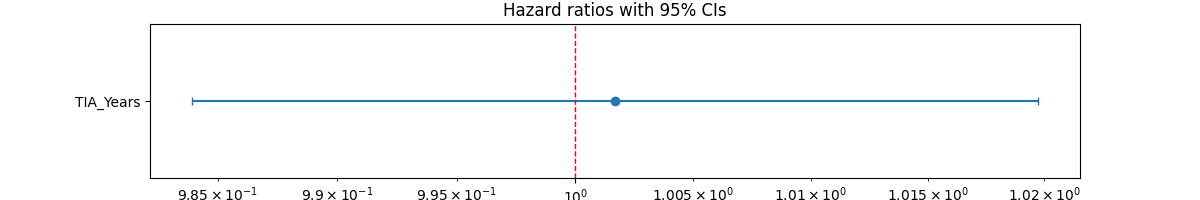

In [107]:
cph_df = df_person[["Time_Yrs", "Event", "TIA_Years"]].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

<lifelines.CoxPHFitter: fitted with 2069 total observations, 1838 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2069
number of events observed = 231
   partial log-likelihood = -1670.0140
         time fit was run = 2025-12-30 09:34:38 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HT_Years  -0.0006    0.9994    0.0022         -0.0050          0.0038              0.9950              1.0038

           cmp to       z      p  -log2(p)
covariate                                 
HT_Years   0.0000 -0.2675 0.7891    0.3418
---
Concordance = 0.4172
Partial AIC = 3342.0280
log-likelihood ratio test = 0.0710 on 1 df
-log2(p) of ll-ratio test = 0.3402

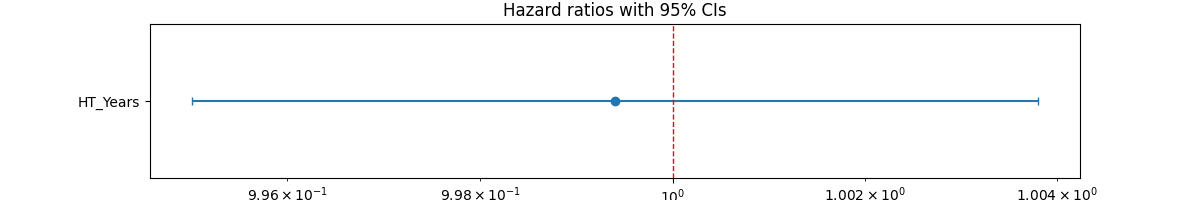

In [108]:
cph_df = df_person[["Time_Yrs", "Event", "HT_Years"]].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

<lifelines.CoxPHFitter: fitted with 413 total observations, 358 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 413
number of events observed = 55
   partial log-likelihood = -309.9147
         time fit was run = 2025-12-30 09:34:38 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Diab_Years -0.0033    0.9967    0.0040         -0.0110          0.0045              0.9890              1.0045

            cmp to       z      p  -log2(p)
covariate                                  
Diab_Years  0.0000 -0.8281 0.4076    1.2948
---
Concordance = 0.4555
Partial AIC = 621.8295
log-likelihood ratio test = 0.6400 on 1 df
-log2(p) of ll-ratio test = 1.2388

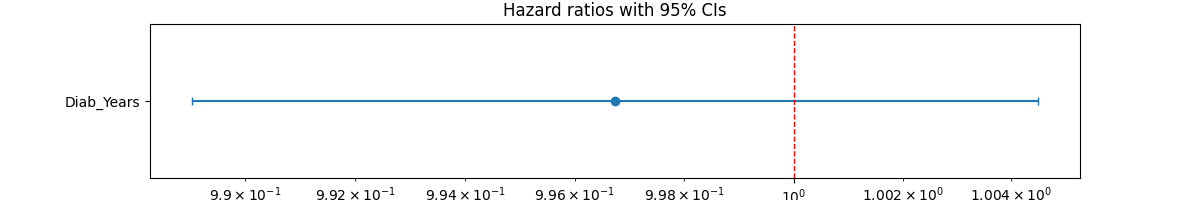

In [109]:
cph_df = df_person[["Time_Yrs", "Event", "Diab_Years"]].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

<lifelines.CoxPHFitter: fitted with 205 total observations, 164 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 205
number of events observed = 41
   partial log-likelihood = -196.0926
         time fit was run = 2025-12-30 09:34:39 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
MI_Years  -0.0014    0.9986    0.0084         -0.0179          0.0152              0.9823              1.0153

           cmp to       z      p  -log2(p)
covariate                                 
MI_Years   0.0000 -0.1605 0.8725    0.1968
---
Concordance = 0.4541
Partial AIC = 394.1852
log-likelihood ratio test = 0.0257 on 1 df
-log2(p) of ll-ratio test = 0.1965

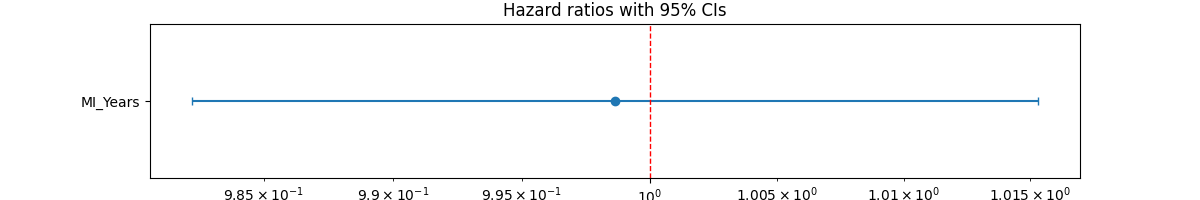

In [110]:
cph_df = df_person[["Time_Yrs", "Event", "MI_Years"]].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

#### Results

From the results, none of the years of having the conditions (HT, MI, TIA, Diabetes) shows statistically significant correlation with difference in 
stroke risk.
They are also not valid predictors in the Cox model.

### Assess effectiveness of HT and diabetes treatments

Since data is available on individuals receiving HT and diabetes treatments, it is possible to assess whether such treatments mediate
or reduce risks of stroke.

From results in first round of Cox model evaluation,

#### 1. HT under treatment is still associated with higher stroke risk.

HT may contribute to a higher stroke risk. Having HT under treatment, however, does not eliminate this higher risk. Results show that
having HT under treatment has around 52.53% higher stroke risk than others. On the other hand, predictors based on untreated HT and HT alone
are not valid, nor statistically significant.

As there is no statistically significant correlation between untreated HT for stroke risk to compare with that between treated HT with stroke
risk, it is unable to verify findings in Han et al., 2017, which is untreated HT contributes to higher stroke risk compared to treated HT.

#### 2. Diabetes under treatment is still associated with higher stroke risk.
   
Diabetes may be associated with a higher stroke risk. However, diabetes under treatment of drugs does not eliminate this risk. Results
show that diabetes under treatment has around 1.5% higher stroke risk than others. On the other hand, predictors for untreated diabetes
and diabetes alone are not valid, nor statistically significant.

Therefore, from the results, treatment of HT and diabetes does not mediate or reduce stroke risk. Monitoring and stroke prevention strategies 
should be implemented primarily for population with such conditions, even if they are under treatment. 

### Recent symptoms and short-term stroke risk

This part will assess correlation between recent occurrence of symptoms and stroke events after them.

Since previously, whether having TIA affects stroke risk was unknown due to it causing errors in the Cox model, this condition is brought down to this part
to analyze again. Others like having MI are also brought down.

**Strategy**
For each person, find stroke event, and look for symptoms in all waves before it. This creates a $2\times2$ contingency table like such,

|                | Symptom | No Symptom |
|----------------|---------|------------|
| **Stroke**     |   _a_   |     _b_    |
| **No stroke**  |   _c_   |     _d_    |

_a_ = stroke with symptom, _b_ = stroke without symptom,
_c_ = symptom but no stroke, _d_ = no symptom and no stroke.

A Fisher's exact test is run on this contingency table to produce odds ratio and a $p$-value.
Higher odds ratio ($\text{odds} \gg 1$) means that the symptom is much more likely to occur before stroke. Lower $p$ ($p < 0.05$) means such a result
is statistically significant.

Also, a Kaplan-Meier model was fit with population with symptom and those without. Such a model estimates survival probability of population with
variation of independent variable. Define survival as being free of stroke. A survival function (probability of being stroke-free) for both cases where the
symptom occured and did not occur were calculated and contrasted.

#### Feature extraction

This part calculates values for contigency table by counting _a_, _b_, _c_ and _d_ values as mentioned earlier, for each symptom in,

- `Headache_Last4` - Having a headache in last 4 weeks
- `Chestpain_Last4` - Having a chest pain in last 4 weeks
- `Exhausion_Last4` - Feeling exhaustion in last 4 weeks
- `Unknown_Bleed_Last4` - Had unknown bleeding in last 4 weeks
- `Unknown_WghtLoss_Last4` - Had weight loss of unknown cause in last 4 weeks
- `Had_TIA` - Having TIA in last year
- `Has_MI` - Having MI conditions

, in all previous waves before stroke occured.

In [111]:
symptom_names = [
    "Headache_Last4",
    "Chestpain_Last4",
    "Exhaustion_Last4",
    "Unknown_Bleed_Last4",
    "Unknown_WghtLoss_Last4",
    "Had_TIA",
    "Has_MI",
]

# Count at stroke waves
stroke_symptom_counts = {symptom: [0, 0] for symptom in symptom_names}
num_stroke = 0

for pid, df in persons.items():
    df = df.sort_values("Wave").reset_index(drop=True)
    stroke_idx = df.index[df["Has_Apopl"] == 1].tolist()
    if stroke_idx:
        idx = stroke_idx[0]
        symptoms_present = df.loc[idx, symptom_names]
        if not symptoms_present.isnull().all():
            num_stroke += 1
            for s in symptom_names:
                if symptoms_present[s] == 1:
                    stroke_symptom_counts[s][0] += 1
                else:
                    stroke_symptom_counts[s][1] += 1

# Count at non-stroke waves
symptom_any_nostroke = {symptom: [0, 0] for symptom in symptom_names}
total_nostroke = 0
for pid, df in persons.items():
    df = df.sort_values("Wave").reset_index(drop=True)
    nostroke_df = df[df["Has_Apopl"] == 0]
    total_nostroke += len(nostroke_df)
    for s in symptom_names:
        n_present = (nostroke_df[s] == 1).sum()
        n_absent = (nostroke_df[s] == 0).sum()
        symptom_any_nostroke[s][0] += n_present
        symptom_any_nostroke[s][1] += n_absent

rows = []
for pid, df in persons.items():
    df = df.sort_values("Wave").reset_index(drop=True)
    # Find stroke event time
    stroke_rows = df[df["Has_Apopl"] == 1]
    baseline_wave = df["Wave"].iloc[0]
    if len(stroke_rows) > 0:
        event = 1
        event_wave = stroke_rows["Wave"].iloc[0]
        time_yrs = event_wave - baseline_wave
    else:
        event = 0
        event_wave = None
        time_yrs = df["Wave"].iloc[-1] - baseline_wave
    # Calculate ever-occurrence flags
    rec = {"ID": pid, "Time_Yrs": time_yrs, "Event": event}
    for s in symptom_names:
        rec[s + "_EVER"] = int((df[s] == 1).any())
    rows.append(rec)
df_symptom_ever = pd.DataFrame(rows)

#### Contigency table for each symptom

In [112]:
# Output contingency tables for each symptom
for s in symptom_names:
    print(f"\nSymptom: {s}")
    table = pd.DataFrame(
        {"Stroke": stroke_symptom_counts[s], "No Stroke": symptom_any_nostroke[s]},
        index=["Symptom", "No Symptom"],
    )
    display(table)

    total = table.sum(axis=1)
    print(
        f"Strokes with symptom: {stroke_symptom_counts[s][0]} / {num_stroke} ({stroke_symptom_counts[s][0] / num_stroke:.2%})"
    )
    nostroke_total = symptom_any_nostroke[s][0] + symptom_any_nostroke[s][1]
    print(
        f"No-stroke waves with symptom: {symptom_any_nostroke[s][0]} / {nostroke_total} ({symptom_any_nostroke[s][0] / nostroke_total:.2%})"
    )


Symptom: Headache_Last4


,Stroke,No Stroke
Symptom,44,2138
No Symptom,283,41404


Strokes with symptom: 44 / 327 (13.46%)
No-stroke waves with symptom: 2138 / 43542 (4.91%)

Symptom: Chestpain_Last4


,Stroke,No Stroke
Symptom,25,661
No Symptom,302,42886


Strokes with symptom: 25 / 327 (7.65%)
No-stroke waves with symptom: 661 / 43547 (1.52%)

Symptom: Exhaustion_Last4


,Stroke,No Stroke
Symptom,6,126
No Symptom,321,43435


Strokes with symptom: 6 / 327 (1.83%)
No-stroke waves with symptom: 126 / 43561 (0.29%)

Symptom: Unknown_Bleed_Last4


,Stroke,No Stroke
Symptom,0,8
No Symptom,327,43553


Strokes with symptom: 0 / 327 (0.00%)
No-stroke waves with symptom: 8 / 43561 (0.02%)

Symptom: Unknown_WghtLoss_Last4


,Stroke,No Stroke
Symptom,0,4
No Symptom,327,43557


Strokes with symptom: 0 / 327 (0.00%)
No-stroke waves with symptom: 4 / 43561 (0.01%)

Symptom: Had_TIA


,Stroke,No Stroke
Symptom,23,0
No Symptom,304,43561


Strokes with symptom: 23 / 327 (7.03%)
No-stroke waves with symptom: 0 / 43561 (0.00%)

Symptom: Has_MI


,Stroke,No Stroke
Symptom,24,252
No Symptom,303,43291


Strokes with symptom: 24 / 327 (7.34%)
No-stroke waves with symptom: 252 / 43543 (0.58%)


#### Fisher's exact test for enrichment

Calculate odds ratio and $p$-value.

In [113]:
rows = []
for s in symptom_names:
    # Build the 2x2 table: [ [stroke+symptom, stroke+no_symptom], [nostroke+symptom, nostroke+no_symptom] ]
    stroke_with_symptom = stroke_symptom_counts[s][0]
    stroke_without_symptom = stroke_symptom_counts[s][1]
    nostroke_with_symptom = symptom_any_nostroke[s][0]
    nostroke_without_symptom = symptom_any_nostroke[s][1]

    # 2x2 contingency table for Fisher's test
    table = [
        [stroke_with_symptom, stroke_without_symptom],
        [nostroke_with_symptom, nostroke_without_symptom],
    ]
    oddsratio, pvalue = stats.fisher_exact(table)

    # Save both the table and the association stats
    rows.append(
        [
            oddsratio,
            pvalue,
            f"{stroke_with_symptom} / {stroke_with_symptom + stroke_without_symptom}",  # Strokes with symptom / all strokes
            f"{nostroke_with_symptom} / {nostroke_with_symptom + nostroke_without_symptom}",  # No-strokes with symptom / all no-stroke waves
        ]
    )

out_fisher_df = pd.DataFrame(
    rows,
    columns=[
        "Odds ratio",
        "$p$",
        "Stroke/Total at Stroke",
        "No-Stroke/Total No-Stroke",
    ],
)
out_fisher_df.index = symptom_names
out_fisher_df = out_fisher_df.sort_values("Odds ratio", ascending=False)
out_fisher_df

,Odds ratio,$p$,Stroke/Total at Stroke,No-Stroke/Total No-Stroke
Had_TIA,inf,5.237839e-50,23 / 327,0 / 43561
Has_MI,13.607104,1.501984e-18,24 / 327,252 / 43543
Exhaustion_Last4,6.443406,4.872607e-04,6 / 327,126 / 43561
Chestpain_Last4,5.370901,1.032002e-10,25 / 327,661 / 43547
Headache_Last4,3.010931,2.368314e-09,44 / 327,2138 / 43542
Unknown_Bleed_Last4,0.000000,1.000000e+00,0 / 327,8 / 43561
Unknown_WghtLoss_Last4,0.000000,1.000000e+00,0 / 327,4 / 43561


#### Kaplan-Meier analysis of survival probability

Define survive as being stroke-free. The Kaplan-Meier model fitted here estimates the probablily of being free from stroke, if one of the symptoms
mentioned earlier show up.

,Headache_Last4 EVER (n=1749),Headache_Last4 NEVER (n=6075)
timeline,,
0.0,1.0000,1.0000
22.0,0.8962,0.9495


,Chestpain_Last4 EVER (n=554),Chestpain_Last4 NEVER (n=7270)
timeline,,
0.0,1.0000,1.0000
22.0,0.8338,0.9419


,Exhaustion_Last4 EVER (n=130),Exhaustion_Last4 NEVER (n=7694)
timeline,,
0.0,1.0000,1.0000
22.0,0.8954,0.9353


,Unknown_Bleed_Last4 EVER (n=8),Unknown_Bleed_Last4 NEVER (n=7816)
timeline,,
0.0,1.0000,1.0000
22.0,0.8571,0.9349


,Unknown_WghtLoss_Last4 EVER (n=4),Unknown_WghtLoss_Last4 NEVER (n=7820)
timeline,,
0.0,1.0,1.0


,Had_TIA EVER (n=33),Had_TIA NEVER (n=7791)
timeline,,
0.0,1.0,1.0000
22.0,0.0,0.9454


,Has_MI EVER (n=228),Has_MI NEVER (n=7596)
timeline,,
0.0,1.0000,1.0000
22.0,0.6794,0.9426


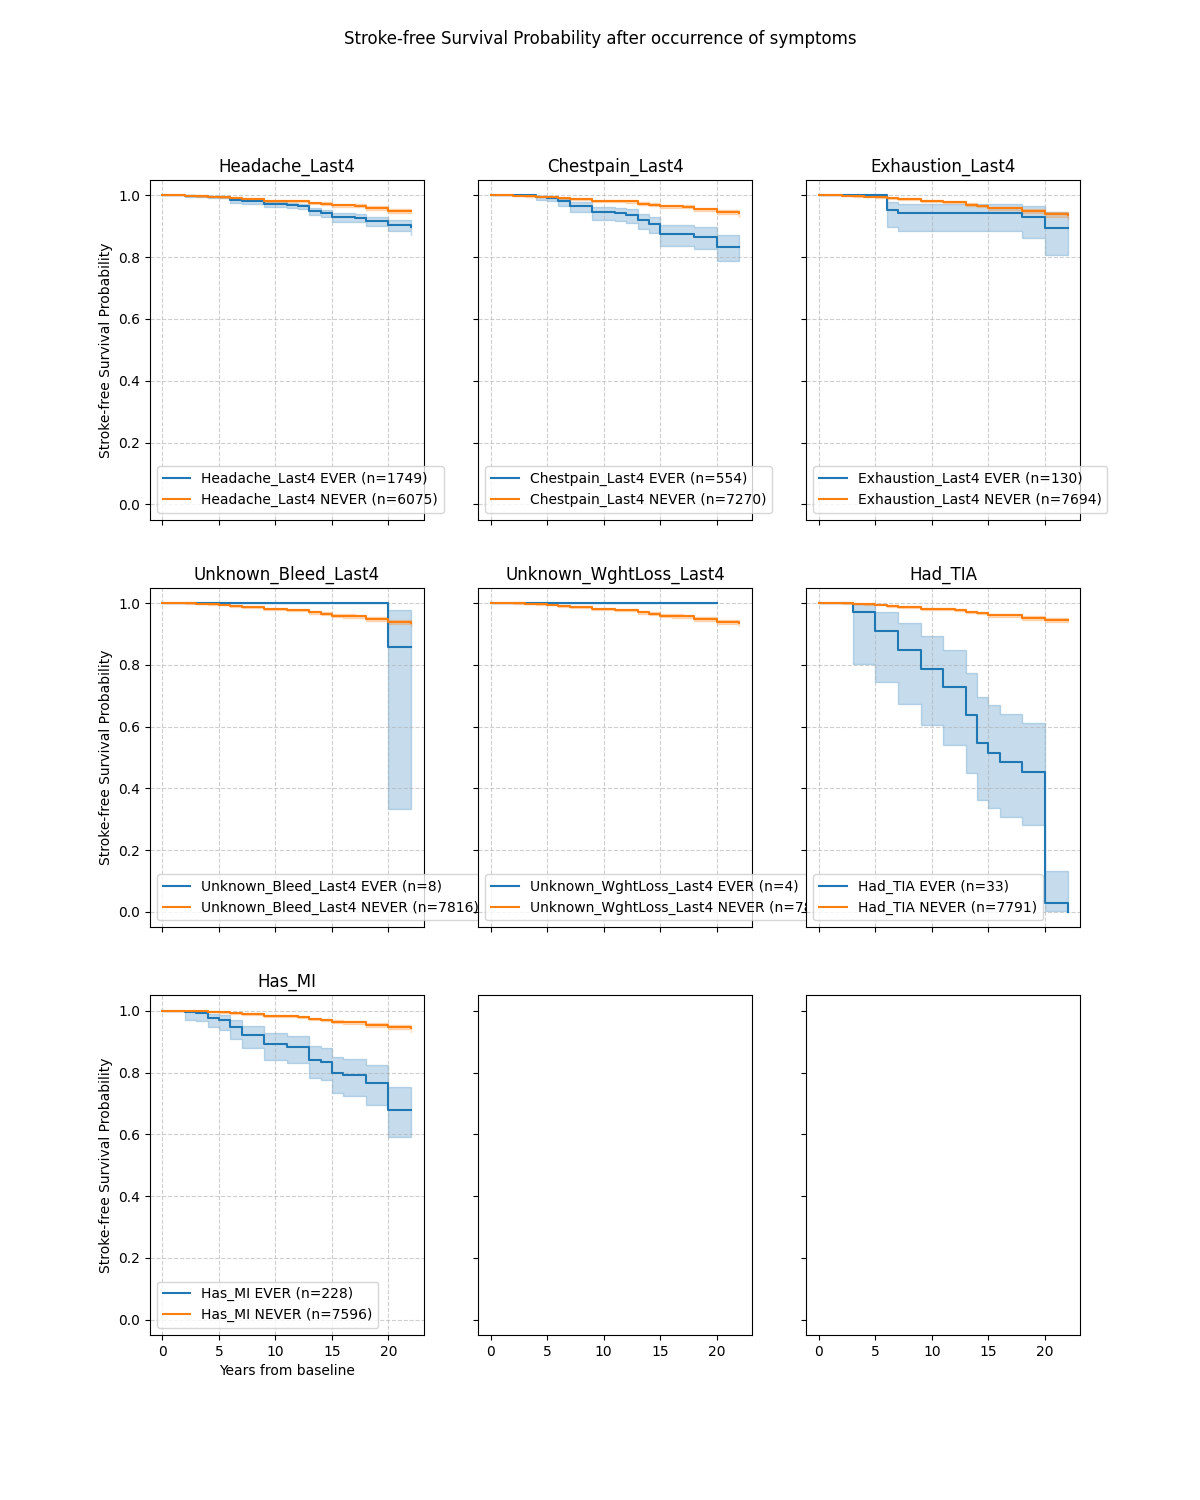

In [114]:
kmf = KaplanMeierFitter()
fig, axes = plt.subplots(3, 3, figsize=(12, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, s in enumerate(symptom_names):
    ax = axes[i]

    # Plot two curves: ever had symptom vs never had symptom
    group_labels = [f"{s} EVER", f"{s} NEVER"]
    survive_df = None
    for val, label, color in zip([1, 0], group_labels, ["tab:red", "tab:blue"]):
        mask = df_symptom_ever[s + "_EVER"] == val
        if mask.sum() > 0:
            kmf.fit(
                df_symptom_ever.loc[mask, "Time_Yrs"],
                event_observed=df_symptom_ever.loc[mask, "Event"],
                label=f"{label} (n={mask.sum()})",
            )
            kmf.plot_survival_function(ax=ax, ci_show=True)

            current_survive_df = kmf.survival_function_.iloc[[0, -1]]
            if survive_df is None:
                survive_df = current_survive_df
            else:
                # Show survival function (start and end)
                survive_df = survive_df.merge(current_survive_df, on="timeline")
                survive_df = survive_df.round(4)
                display(survive_df)
    ax.set_title(s)
    ax.set_xlabel("Years from baseline")
    ax.set_ylabel("Stroke-free Survival Probability")
    ax.grid(True, linestyle="--", alpha=0.6)

plt.suptitle("Stroke-free Survival Probability after occurrence of symptoms")
plt.show()
plt.tight_layout()

From the results,

#### Statistically significant symptoms associated with stroke

1. **Had TIA** ($\text{odds} \gg 1$, $p \ll 0.05$)

   Having TIA symptoms in 1-year window before survey is related very greatly with stroke risk in the subsequent wave.
   As shown by odds ratio being infinity, it means that all 21 individuals surveyed with TIA developed stroke in a subsequent wave.
   Statistically, this result is very significant, shown by the very low $p$ value.

   This agrees with existing literature about risk factors of stroke, where individuals having TIA are extremely likely to develop stroke subsequently.

   Survival probability decreases to 0% at 22 years. This is the highest rate of decrease of stroke-free population, meaning that ever having TIA means
   almost certainty of developing stroke.

2. **Having MI** ($\text{odds} = 13.6071$, $p \ll 0.05$)

   Having MI before survey is related to more than 13 times higher stroke risk in the subsequent wave, and is statistically significant.

   Survival function of it shows the survival probability decreased to 0.6794 at 22 years with exhaustion present, compared to 0.9426 with it absent. 
   The difference is around 26%.

3. **Exhaustion** ($\text{odds} = 6.4434$, $p < 0.05$)

   Exhaustion in 4-week window before survey is related to more than 6 times higher stroke risk in the subsequent wave, and is statistically significant.

   Survival function of it shows the survival probability decreased to 0.8954 at 22 years with exhaustion present, compared to 0.9353 with it absent. 
   The difference is around 4%.

   However, exhaustion as a "symptom" is not a specific description. Also, only 6 individuals out of 304 with stroke experienced exhaustion in 4-month
   windows 1 wave before stroke. This result should be taken with a grain of salt.

4. **Chest pain** ($\text{odds} = 5.3709$, $p \ll 0.05$)

   Chest pain in 4-week window before survey is related to more than 5 times higher stroke risk in the subsequent wave, and is statistically significant.

   Its survival function shows the survival probability decreased to 0.8338 at 22 years with exhaustion present, compared to 0.9419 with it absent. The 
   difference is around 10%, which is the greatest among all.

   Clinically, chest pain may indicate cardiovascular issues.
   Some of which, like HT (under treatment), has been proven to be correlated with a higher stroke risk.

5. **Headache** ($\text{odds} = 3.0109$, $p \ll 0.05$)

   Headache in 4-week window before survey is related to more than 3 times higher stroke risk in the subsequent wave, and is statistically significant.

   Its survival function shows the survival probability decreased to 0.8692 at 22 years with exhaustion present, compared to 0.9299 with it absent. The 
   difference is around 6%.

For 2 other symptoms, which are having bleeding of unknown cause and having weight loss of unknown cause, not enough data are available to support any
claims to be made, as survival functions for cases where each symptom is present and absent are not complete.

Therefore, adding to the criteria for population with prioritized access to BP monitoring,

1. Population who have had a TIA or MI in recent years, and,
2. Population who shows symptoms of headache, chest pain, and exhaustion in recent years.

### Evaluate criteria for monitoring scheme

In previous sections, the following criteria for prioritized access to BP monitoring schemes are found,

1. Population with higher DBP or SBP
2. Population with HT conditions or diabetes conditions (under treatment)
3. Population with higher BMI
4. Older population
5. Population who have had MI or TIA in recent years
6. Population who shows symptoms of headache, chest pain, and exhaustion in recent years.

To facilitate applying the criteria, a binary classification method based on determined cut-offs shall be used. Define positive as being susceptible to
higher stroke risk, cut-offs for these criteria can be found to facilitate applying them.

This part finds optimal cut-offs for criteria, that satisfies the following,

- **Being easy to apply**
  
  Have a clear cut-off with binary classification
- **Minimizes enforcement workload (WUD)**

  The criteria should flag a manageable portion of the population as positive. This is judged from two factors, Work-up to detection (WUD) and population
  yield. Both should be kept at a manageable level.
  
  WUD is defined as the number of people to flag and monitor, in order to catch one true positive case (having stroke).
  Mathematically, it is defined as

  $$ \text{WUD} = \frac{1}{\text{PPV}} $$

  It can be seen that the smaller this value is, the smaller the population is needed to screen to detect true positive cases, and thus the smaller
  the workload to enfore such criteria.
- **Maximizes Positive Predictive Value (PPV)**

  Positive Predictive Value (PPV) is defined as the probability that a person who tests positive (predicted higher stroke risk) is actually positive
  (develops stroke).

  Mathematically, it is defined as,

  $$ \text{PPV} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

  TP = True positive, FP = false positive. In other words, it measures the rate of actual positives among all positive predictions.
- **Maximizes Sensitivity**

  Higher sensitivity means a higher rate of predicting actual future strokes.

  Mathematically, it is defined as,

  $$ \text{Sensitivity} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

  TP = True positive, FN = false negative. In other words, it measures the rate of positives detected in all who later turned positive.

The following factors require finding optimal cut-offs,

1. Population with higher DBP or SBP (cut-off DBP and SBP measured in mmHg)
2. Population with higher BMI (cut-off BMI value)
3. Older population (cut-off age)
4. Population who have had a MI or TIA in recent years (cut-off time range to trace back)

> **Note**
>
> Since data about occurrence of symptoms like headache, chest pain and exhaustion are only recorded in 4-week windows before each survey,
> they may be inaccurate, as they may not accurately represent actual occurrence of such symptoms.
> Therefore, they are exempted from cutoff analysis.

**Strategy**
This part will iterate through a range of cut-offs, and run a function to evaluate their performance. The following factors are considered,

- **Youden's index**, calculated by
    - **Sensitivity** - True positive rate
    - **Specificity** - True negative rate
- **Population yield** - Amount of population flagged positive.
- **WUD** - Work needed to detect a positive case.

Youden's index is defined as

$$ J = \text{Sensitivity} + \text{Specificity} − 1 $$

#### Helper functions for evaluating optimal cutoff value

This `evaluate_cutoff` function evaluates the effect on screening with the following factors

In [115]:
def evaluate_cutoff(var, cutoffs, compare, df, outcome="Event"):
    perf_rows = []
    for cutoff in cutoffs:
        if compare == "geq":
            flag = df[var] >= cutoff
        elif compare == "leq":
            flag = df[var] <= cutoff
        else:
            raise ValueError("compare must be 'geq' or 'leq'")
        TP = ((flag) & (df[outcome] == 1)).sum()
        FP = ((flag) & (df[outcome] == 0)).sum()
        FN = ((~flag) & (df[outcome] == 1)).sum()
        TN = ((~flag) & (df[outcome] == 0)).sum()
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        PPV = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        WUD = 1 / PPV
        PopulationYield = flag.mean()
        youden = (
            sensitivity + specificity - 1
            if not (np.isnan(sensitivity) or np.isnan(specificity))
            else np.nan
        )
        perf_rows.append(
            dict(
                Cutoff=cutoff,
                Sensitivity=sensitivity,
                Specificity=specificity,
                PPV=PPV,
                PopulationYield=PopulationYield,
                Youden=youden,
                WUD=WUD,
            )
        )
    return pd.DataFrame(perf_rows)


def plot_perf(df_perf, /, varname, xlabel, optimal_df=None):
    plt.figure(figsize=(10, 6))

    plt.plot(df_perf["Cutoff"], df_perf["Sensitivity"], label="Sensitivity", marker="o")
    plt.plot(df_perf["Cutoff"], df_perf["PPV"], label="PPV", marker="s")
    plt.plot(
        df_perf["Cutoff"],
        df_perf["PopulationYield"],
        label="Population Yield",
        marker="^",
    )
    plt.plot(df_perf["Cutoff"], df_perf["Youden"], label="Youden Index", marker="+")

    plt.xlabel(xlabel)
    plt.ylabel("Metric Value")
    plt.title(f"Screening Performance vs {varname}")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    if optimal_df is not None:
        optimal_label = optimal_df["Cutoff"]

        plt.axvline(optimal_label, color="black", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

#### Set ranges of test values

As age at baseline was filtered to be within 45-80 years of age, test values of age cutoff must be within this range as well. This ensures a meaningful
comparison.

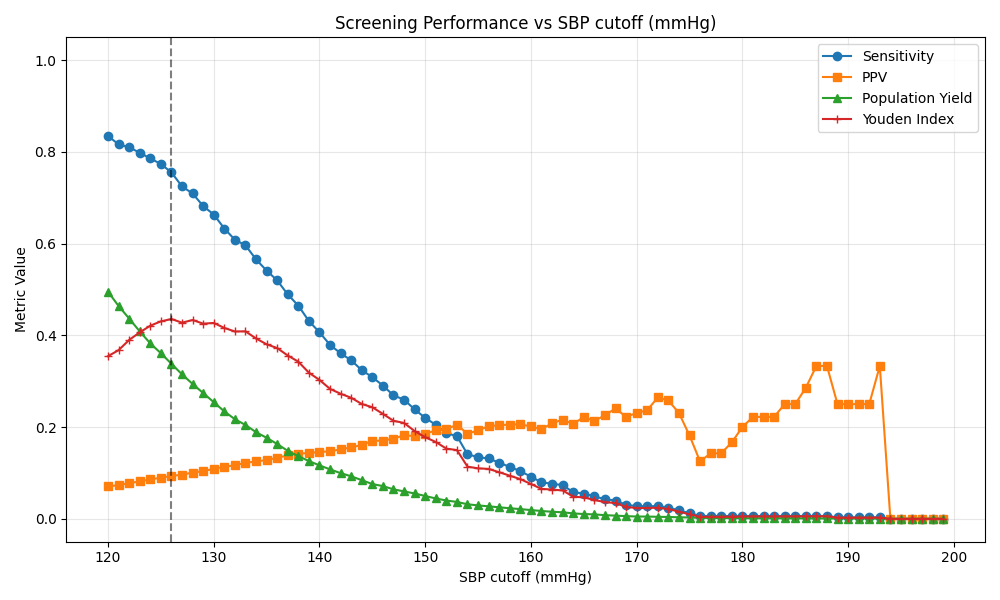

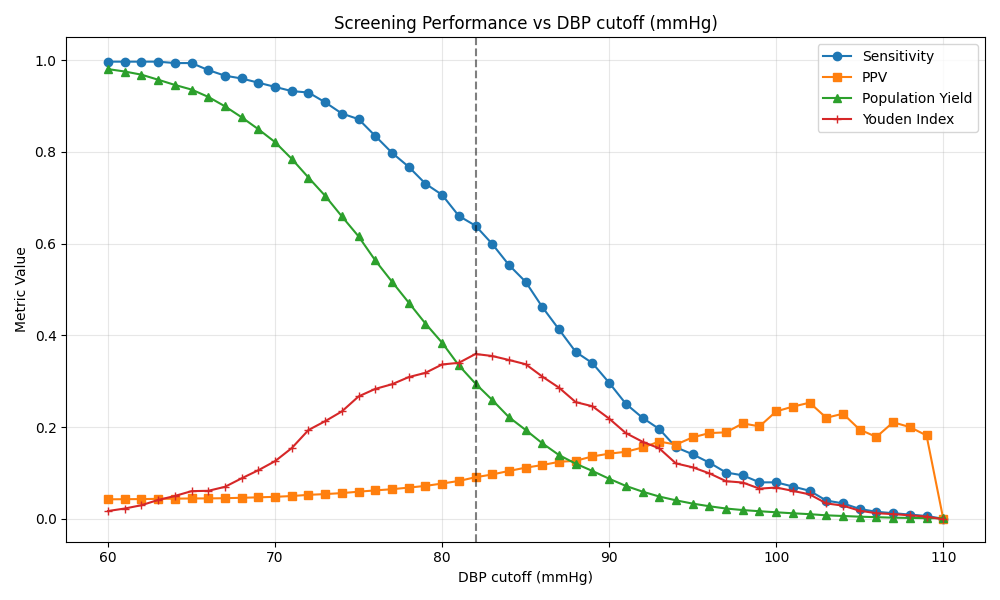

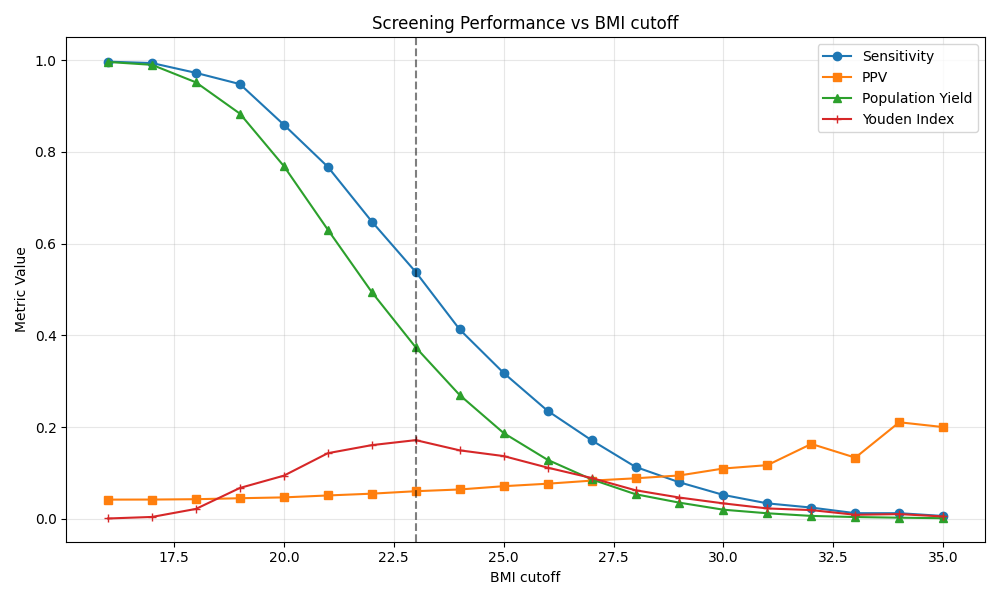

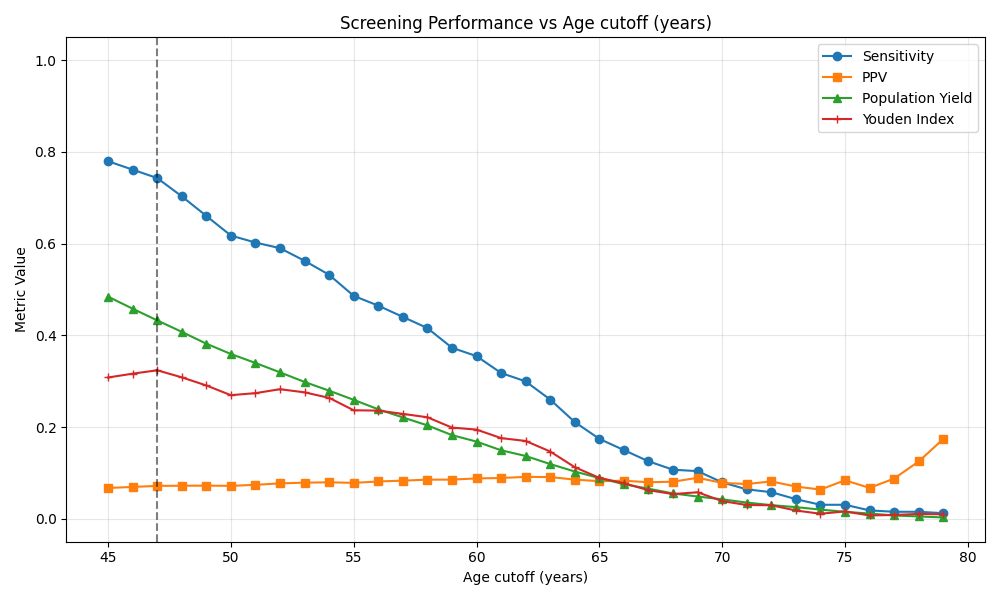

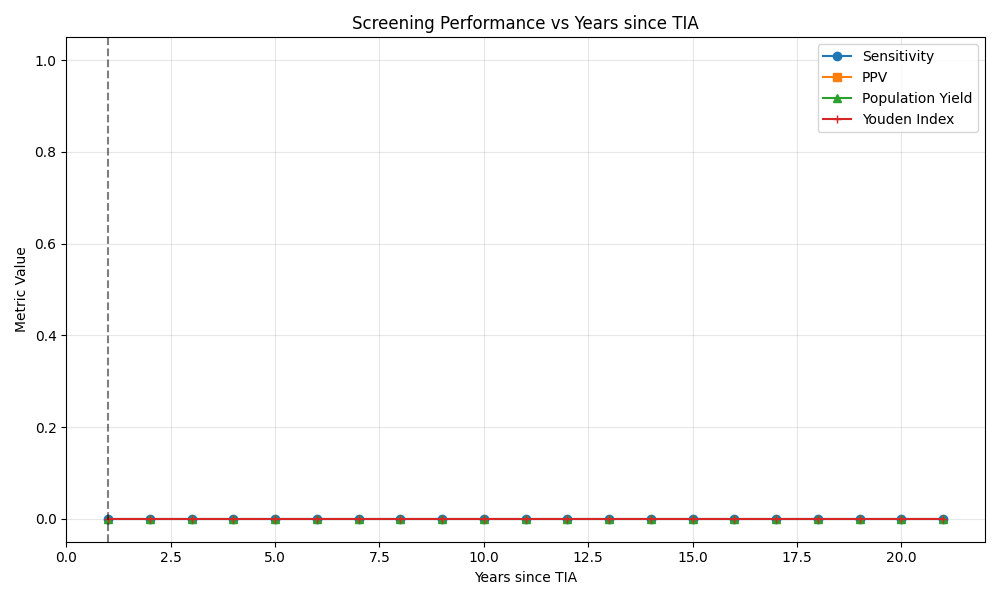

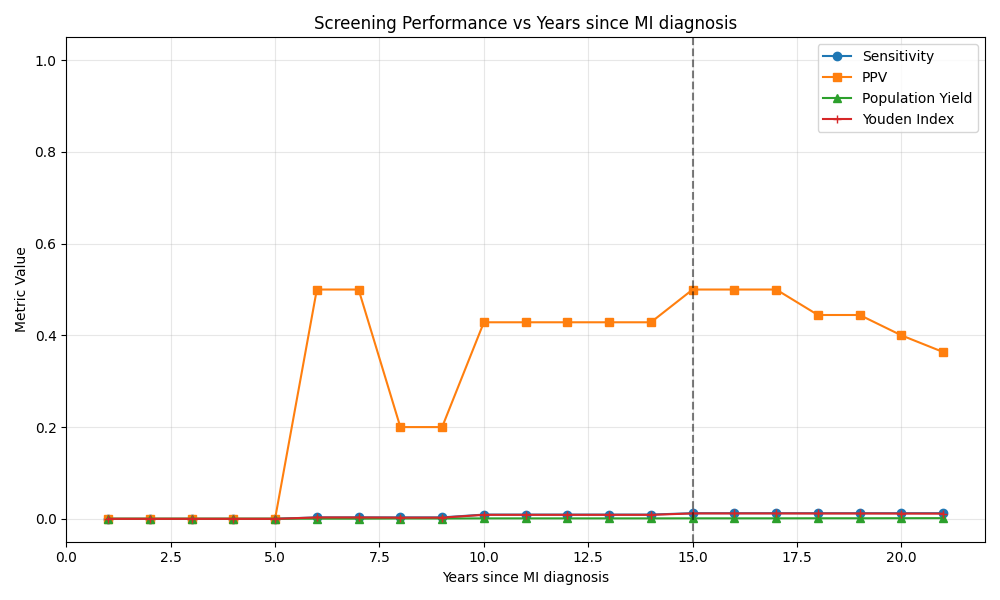

,SBP cutoff (mmHg),DBP cutoff (mmHg),BMI cutoff,Age cutoff (years),Years since TIA,Years since MI diagnosis
Cutoff,126.0000,82.0000,23.0000,47.0000,1.0,15.0000
Sensitivity,0.7554,0.6391,0.5382,0.7431,0.0,0.0122
Specificity,0.6803,0.7203,0.6333,0.5808,1.0,0.9995
PPV,0.0934,0.0906,0.0602,0.0718,NaN,0.5000
PopulationYield,0.3379,0.2947,0.3738,0.4328,0.0,0.0010
Youden,0.4356,0.3594,0.1715,0.3239,0.0,0.0117
WUD,10.7045,11.0335,16.6193,13.9342,NaN,2.0000


In [116]:
# Prepare test values
sbp_cutoffs = np.arange(120, 200, 1)
dbp_cutoffs = np.arange(60, 111, 1)
bmi_cutoffs = np.arange(16, 36, 1)
age_cutoffs = np.arange(45, 80, 1)
symptom_lookback = np.arange(1, 22, 1)

df_perf_sbp = evaluate_cutoff("Mean_SBP", sbp_cutoffs, compare="geq", df=df_person)
df_perf_dbp = evaluate_cutoff("Mean_DBP", dbp_cutoffs, compare="geq", df=df_person)
df_perf_bmi = evaluate_cutoff("BMI", bmi_cutoffs, compare="geq", df=df_person)
df_perf_age = evaluate_cutoff("Age_Baseline", age_cutoffs, compare="geq", df=df_person)

df_perf_TIA = evaluate_cutoff(
    "TIA_Years", symptom_lookback, compare="leq", df=df_person
)
df_perf_MI = evaluate_cutoff("MI_Years", symptom_lookback, compare="leq", df=df_person)

# For each variable, find and print Youden-optimal cut and plot
perf_names = [
    (df_perf_sbp, "SBP cutoff (mmHg)"),
    (df_perf_dbp, "DBP cutoff (mmHg)"),
    (df_perf_bmi, "BMI cutoff"),
    (df_perf_age, "Age cutoff (years)"),
    (df_perf_TIA, "Years since TIA"),
    (df_perf_MI, "Years since MI diagnosis"),
]

rows_perf = {}
for df_perf, xlabel in perf_names:
    idx = df_perf["Youden"].idxmax()
    optimal_df = df_perf.loc[idx]
    rows_perf[xlabel] = optimal_df.to_dict()
    plot_perf(df_perf, xlabel, xlabel, optimal_df=optimal_df)

summary_df = pd.DataFrame(rows_perf)
display(summary_df.round(4))

#### Evaluation on cutoffs

##### 1. SBP and DBP

(**SBP**: WUD = 10.7045, Population yield = 0.3379, Sensitivity = 0.7554)

(**DBP**: WUD = 11.0335, Population yield = 0.2947, Sensitivity = 0.6391)

By maximizing Youden's index, cutoff values are determined to be at higher than 82/130 mmHg.

SBP and DBP at 126 mmHg and 82 mmHg respectively roughly match reference values of Stage 1 hypertension, which are 80/130 mmHg (American Heart Association,
2022). Around 10.7-11 people must be screened before one case of stroke can be predicted accurately, around 1/3 of the population would be flagged positive.
Sensitivity is around 63-75%.

##### 2. BMI

(WUD = 16.6193, Population yield = 0.3738, Sensitivity = 0.5382)

By maximizing Youden's index, cutoff value is determined to be at higher than 23.0. Sensitivity is at around 53.82%. It flags around 37% of the
population positive.

However, PPV does not increase much when cutoff values increase. The maximum is at around 0.2, decreasing WUD to 5 people. 
Nevertheless, BMI 23.0 is within normal range of BMI values, and sensitivity of this cutoff is only at 53%,
such a cutoff value is not particularly significant in real life.

##### 3. Age

(WUD = 13.9342, Population yield = 0.4328, Sensitivity = 0.7431)

By maximizing Youden's index, cutoff value is determined to be at higher than 47 years at baseline. Sensitivity is at around 74%. Around 43% of the
population is flagged positive. This matches roughly the "middle-aged" age group determined from existing research (Geifman et al., 2013), which is
defined as 49-60 years of age.

##### 4. Lookback Years since symptoms

**TIA**

By maximizing Youden's index, cutoff lookback years is determined to be at 1 year. However, Youden's index is at 0.0, and PPV and WUD cannot be calculated normally.
This shows that there has been errors in the computation, and this result should not be used.

Even so, previous results show that occurrence of TIA has a very high correlation with stroke. Occurrence of TIA at any point should be treated with 
follow-up actions.

**MI**

(WUD = 2.0000, Population yield = 0.0010, Sensitivity = 0.0122)

By maximizing Youden's index, cutoff lookback years is determined to be at 15 years. However, neither Youden's index nor PPV particularly increase as the cutoff value varies. This shows a cutoff value matters little to monitoring schemes, as WUD therefore created varies little, and sensitivity does not significantly increase.

Therefore, this cutoff value is not particularly significant.
Even so, previous results show that occurrence of MI has a very high correlation with stroke. Occurrence of MI at any point should be treated with
follow-up actions.

#### Conclusion / Criteria for prioritized BP monitoring scheme access

In conclusion, cutoffs for prioritized BP monitoring scheme access should be,

- **SBP/DBP** - 82/130 mmHg
- **Age** - Above 47 years
- **TIA** and **MI** - Diagnosed in the past

Other factors are
- **HT** - Condition present, under treatment
- **Diabetes** - Condition present, under treatment
- **Symptoms** - Headache, chest pain, exhaustion present in the past

Population that match these criteria should get admitted to a BP monitoring scheme that continues to track occurrences / values of such factors, and new
stroke risks are continuously evaluated over time. When necessary, intervention strategies against strokes shall be taken when stroke risk becomes high.

## Proposed Health Policy and Innovative Health Technology Solution

### Policy Recommendation

Extend factors screened in CDCC and introduce a stroke risk screening program as an extension to the CDCC Pilot Scheme.
In addition existing screening for HT and diabetes in CDCC, monitoring for medical conditions such as TIA and MI and symptoms such as headache,
chest pain and exhaustion can be added. Admit those who satisfy cutoff values previously found to the stroke risk screening program, where those with
higher stroke risk receive proactive stroke prevention treatment alongside existing CDCC treatment for chronic diseases.

#### Synthesis

As pointed out in literature review, stroke is related to a variety of factors, such as medical history of TIA, not just HT conditions (high BP).
It is also found out during analysis of data that conditions like MI and symptoms such as headache, chest pain and exhaustion are related with stroke
risk.

Therefore, only by using multifactoral monitoring can stroke risk be accurately identified and treated in time. However, current screening programs
does not include screening for most of the factors found out to be related with stroke risk. If this were implemented, it would make the CDCC more
efficient and effective in preventing strokes, supporting the scheme’s mission of better health for people living with chronic diseases in Hong Kong.

#### Implementation & Evaluation

The implementation of such scheme can be described using the Sense-Think-Act framework.

- **Sense** - Collect additional data alongside screening for HT and diabetes in CDCC
    - Medical history in past year (TIA and MI)
    - Symptoms in past year (headache, chest pain, exhaustion)

  **<u>Stakeholders involved</u>**
    - **CDCC participants** - Answer screening questions about medical history and symptoms, then receive measurements of BP and other checks in CDCC.
    - **Family doctor assigned**
- **Think**

### Technology Description

#### Value Proposition

#### Feasibility

## AI usage note

This project was completed with the help of AI to,

- Refine language
- Suggest suitable data analysis methods
- Generate boilerplate code for analysis
- Help understand statistical concepts
- Parse literature data found manually

## References

```
Centers for Disease Control and Prevention. (2024, May 15). Risk factors for stroke. Centers for Disease Control and Prevention. https://www.cdc.gov/stroke/risk-factors/index.html
Boehme, A. K., Esenwa, C., & Elkind, M. S. (2017). Stroke Risk Factors, Genetics, and Prevention. Circ Res, 120(3), 472–495. https://doi.org/10.1161/circresaha.116.308398 
Centre for Health Prevention. (2025). Non-Communicable Diseases Watch October 2025 - Be Stroke Aware. Centre for Health Prevention. https://www.chp.gov.hk/files/pdf/ncd_watch_oct_2025_en.pdf
Han, T. S., Wang, H. H., Wei, L., Pan, Y., Ma, Y., Wang, Y., Wang, J., Hu, Z., Sharma, P., & Chen, R. (2017). Impacts of undetected and inadequately treated hypertension on incident stroke in China. BMJ Open, 7(10), e016581. https://doi.org/10.1136/bmjopen-2017-016581
American Heart Association. (2022). NHCI Community Screening Guidance Package Nov 2022 (4).PDF. NHCI Community Screening Guidance Package Nov 2022 (4).pdf | Community Health Care Association of New York State. https://www.chcanys.org/document/nhci-community-screening-guidance-package-nov-2022-4pdf 
Geifman, N., Cohen, R., & Rubin, E. (2013). Redefining meaningful age groups in the context of disease. Age (Dordrecht, Netherlands), 35(6), 2357–2366. https://doi.org/10.1007/s11357-013-9510-6
```